In [1]:
import sys
import numpy as np
from matplotlib import animation, rc
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
from matplotlib.collections import LineCollection

from functools import reduce
import operator

import torch
from torch import nn
from torch.nn.utils import clip_grad_norm
from torch.autograd import Variable
from torch import optim

#from models import EulerRNN
from RateUnitNetwork import RateUnitNetwork

%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Helper Functions

In [2]:
def var_penalty(xt0,xt1):
    return torch.sqrt(torch.pow(xt1-xt0, 2).mean())

def batch_var_penalty(hiddens):
    return hiddens.std(dim=1).mean()

def l2_penalty(w):
    return torch.sqrt(torch.pow(w,2).mean())

def get_batch(input_size, xmin, xmax, batch_size, n_steps):
    x0 = np.random.uniform(xmin, xmax, size=(batch_size, input_size))
    inputs = Variable(torch.zeros(batch_size, n_steps, input_size))
    targets = inputs.clone()
    inputs[:,0,:] = torch.from_numpy(x0)
    targets[...] = torch.from_numpy(x0).unsqueeze(1) # to get expansion over time
    return inputs, targets


def get_batch(input_size, xmin, xmax, batch_size, n_steps, pulse_width = 1):
    x0 = np.random.uniform(xmin, xmax, size=(batch_size, input_size))
    inputs = Variable(torch.zeros(batch_size, n_steps, input_size))
    targets = inputs.clone()
    inputs[:,:pulse_width,:] = torch.from_numpy(x0).unsqueeze(1)
    #CHECKME JK!
    targets[...] = torch.from_numpy(x0).unsqueeze(1) # to get expansion over time
    return inputs, targets

#     x0 = np.random.uniform(xmin, xmax, size=(batch_size, input_size))
#     inputs = Variable(torch.zeros(batch_size, init_steps+n_steps, input_size))
#     targets = inputs.clone()
#     inputs[:,init_steps,:] = torch.from_numpy(x0)
#     targets[:,init_steps:,:] = torch.from_numpy(x0).unsqueeze(1) # to get expansion over time
#     return inputs, targets

# (hyper)parameters

In [3]:
# Inputs
input_size = 2
xmin = -1
xmax = 1

# Integration
dt = 0.1
tau = 1 # Implicit in RateUnitNetwork
n_steps = int(100*tau/dt)

# Training
n_epochs = 8000
init_steps = int(20*tau/dt) # initialize randomly and run for 20 tau before injecting input
pulse_width = int(5*tau/dt)

#NOTUSED bptt_steps = 5
batch_size = 64
#NOTUSED penalize_fixed = True
eta = 0.001
#lam = 0.001

# Model Architecture
hidden_size = 400
prob_conn = 0.25
g = 1.5

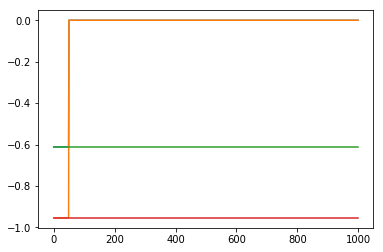

In [4]:
foo, bar = get_batch(input_size, xmin, xmax, batch_size, n_steps, pulse_width)
_=plt.plot(np.arange(n_steps), *foo[0].numpy().T) #, *batch_targets[0][1].numpy().T)
_=plt.plot(np.arange(n_steps), *bar[0].numpy().T) #, *batch_targets[0][1].numpy().T)

In [5]:
model = RateUnitNetwork(input_size, hidden_size, input_size, dt)
model.init_h2h(prob_conn, g)
#model.h2h.weight.register_hook(lambda x: print(torch.norm( (x / model.h2h.weight)[h2h_mask])))
#model.h2h.weight.register_hook(lambda x: print(torch.norm((x / model.h2h.weight)[np.where(h2h_mask)])))

i2h = model.i2h.weight.detach().numpy()
h2h = model.h2h.weight.detach().numpy()
h2o = model.h2o.weight.detach().numpy()
print('INITIAL (|i2h|, |h2h|, |h2o|) = (%f, %f, %f)' %\
      (np.linalg.norm(i2h), np.linalg.norm(h2h), np.linalg.norm(h2o)) 
     )

# bi2h = model.i2h.bias.detach().numpy()
# #bh2h = model.h2h.bias.detach().numpy()
# bh2o = model.h2o.bias.detach().numpy()
# print('INITIAL (|bias_i2h|, |bias_h2h|, |bias_h2o|) = (%f, %f, %f)' %\
#       (np.linalg.norm(bi2h), 0, np.linalg.norm(bh2o)) 
#      ) #np.linalg.norm(bh2h)

INITIAL (|i2h|, |h2h|, |h2o|) = (28.183464, 29.875076, 1.392575)


# Intrinsic dynamics

In [6]:
test_steps = 1000
test_batch_size = 8

with torch.no_grad():
    test_hidden = 2*torch.rand((test_batch_size, hidden_size))-1
    out, hid = model(torch.zeros(test_batch_size, test_steps, input_size), test_hidden)
    intrinsic_out = out.detach().numpy()
    intrinsic_hid = hid.detach().numpy()

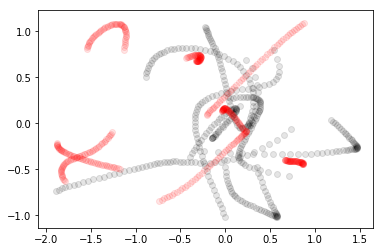

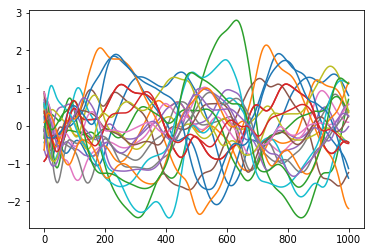

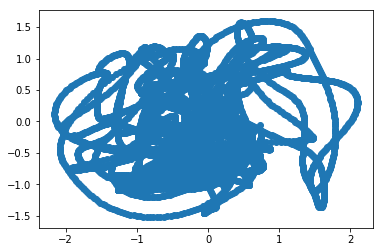

In [7]:
plt.figure()
plt.scatter(*intrinsic_out[:,:int(test_steps/20),:].T, color = 'k', alpha = 0.1)
plt.scatter(*intrinsic_out[:,-int(test_steps/20):,:].T, color = 'r', alpha = 0.1)

plt.figure()
i=np.random.randint(test_batch_size)
k=np.random.randint(0, hidden_size, 25)
_ = plt.plot(intrinsic_hid[i,:,k].T)

plt.figure()
plt.scatter(*intrinsic_out.T)

#     plt.xlim([-1,1])
#     plt.ylim([-1,1])
#plt.scatter(*targets[:,0,:].numpy().T, color='r')
# TODO?: convex hull of samples vs time, as a measure of convergence to single FP

# Train

In [9]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=eta)
losses = np.zeros(n_epochs)
testerr = np.zeros(n_epochs)

len_Wi2h = np.zeros(n_epochs)
len_Wh2h = np.zeros(n_epochs)
len_Wh2o = np.zeros(n_epochs)

# Wi2h = np.zeros((n_epochs, hidden_size, input_size))
# Wh2h = np.zeros((n_epochs, hidden_size, hidden_size))
# Wh2o = np.zeros((n_epochs, input_size, hidden_size))

len_h2h_grad = np.zeros(n_epochs)

for i in range(n_epochs): 
    sys.stdout.write('epoch: %i\n' % i)
    inputs, targets = get_batch(input_size, xmin, xmax, batch_size, n_steps)
    #batch_inputs = torch.split(inputs, bptt_steps, dim = 1)
    #batch_targets = torch.split(targets, bptt_steps, dim = 1)

    # Initialize hidden
    hidden = 2*torch.rand((batch_size, hidden_size))-1
    
    # Integrate for init_steps
    outputs, hiddens = model(torch.zeros(batch_size, init_steps, input_size), hidden)

    # TRAIN FULL INPUT/OUTPUT IN SINGLE PASS
    hidden = hiddens[:,-1,:].detach()
    outputs, hiddens = model(inputs, hidden)
    loss = criterion(outputs, targets)
    model.zero_grad()
    loss.backward()
    losses[i]+=loss.data.item()
    optimizer.step()
    
    #UPDATED1: pass the input pulse but don't train (per Buonomano's implementation)
    #outputs, hiddens = model(inputs[:,:pulse_width,:], hiddens[:,-1,:].detach())
    
    # Initialize hidden
    #hidden = 2*torch.rand((1, hidden_size)) - 1
    # Integrate for init_steps
    #outputs, hiddens = model(torch.zeros(1, init_steps, input_size), hidden)

    #TODO: go back to training 1 pattern at a time and see wtf happens...
    # should be same result, or convergence to that single pattern ... 
    #for j in range(batch_size):
    #    sys.stdout.write('..%i' % j)

    # UPDATED0: BPTT with a window and stepping forward 
    #for t in range(pulse_width, n_steps-bptt_steps):
    #    #batch_in = inputs[[j],t:t+bptt_steps,...]
    #    #batch_tgt = targets[[j],t:t+bptt_steps,...]
    #    #hidden = hiddens[:,[0],:].detach()
    #    batch_in = inputs[:,t:t+bptt_steps,...]
    #    batch_tgt = targets[:,t:t+bptt_steps,...]
    #    hidden = hiddens[:,0,:].detach()
    #    outputs, hiddens = model(batch_in, hidden)
    #    loss = criterion(outputs, batch_tgt)
    #    model.zero_grad()
    #    loss.backward()
    #    #clip_grad_norm(model.parameters(), 0.5) # torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_
    #    len_h2h_grad[i] += np.linalg.norm(model.h2h.weight.grad.detach().numpy())
    #    losses[i]+=loss.data.item()
    #    #print(loss.data[0])
    #    optimizer.step()
    #    #foo.append(model.h2h.weight.detach().numpy())
        
    print('final tbatch err = ', torch.pow(outputs-targets,2).sum(0).mean())
        
    i2h = model.i2h.weight.detach().numpy()
    h2h = model.h2h.weight.detach().numpy()
    h2o = model.h2o.weight.detach().numpy()
    #Wi2h[i] = i2h
    #Wh2h[i] = h2h
    #Wh2o[i] = h2o
    len_Wi2h[i] = np.linalg.norm(i2h)
    len_Wh2h[i] = np.linalg.norm(h2h)
    len_Wh2o[i] = np.linalg.norm(h2o)
    if any([np.isnan(x).any() for x in [i2h, h2h, h2o]]):
        print('NaNs, breaking at epoch=%i...' % i)
        break
#     print('(|i2h|, |h2h|, |h2o|) = (%f, %f, %f)' %\
#           (len_Wi2h[i], len_Wh2h[i], len_Wh2o[i]) )
#         #print('done!\n')
    
#     with torch.no_grad():
#         # Test out of sample performance
#         test_inputs, test_targets = get_batch(input_size, xmin, xmax, batch_size, n_steps, pulse_width)
#         # Initialize hidden
#         hidden = 2*torch.rand((batch_size, hidden_size)) - 1
#         # Integrate for init_steps
#         outputs, hiddens = model(torch.cat((torch.zeros(batch_size, init_steps, input_size),
#                                             inputs), 
#                                            dim = 1),                                           
#                                            hidden)
#         err = criterion(outputs[:,init_steps:,:], test_targets)
#         testerr[i] = err.data[0]

#     print('epoch: %i, loss: %f, testerr %f' % (i, losses[i], testerr[i]))
 

epoch: 0
final tbatch err =  tensor(40.4216)
epoch: 1
final tbatch err =  tensor(34.9530)
epoch: 2
final tbatch err =  tensor(30.9135)
epoch: 3
final tbatch err =  tensor(34.4511)
epoch: 4
final tbatch err =  tensor(29.2940)
epoch: 5
final tbatch err =  tensor(27.1203)
epoch: 6
final tbatch err =  tensor(26.1733)
epoch: 7
final tbatch err =  tensor(27.1336)
epoch: 8
final tbatch err =  tensor(25.4539)
epoch: 9
final tbatch err =  tensor(23.2506)
epoch: 10
final tbatch err =  tensor(24.7786)
epoch: 11
final tbatch err =  tensor(27.4594)
epoch: 12
final tbatch err =  tensor(29.7399)
epoch: 13
final tbatch err =  tensor(24.0381)
epoch: 14
final tbatch err =  tensor(28.7103)
epoch: 15
final tbatch err =  tensor(26.5700)
epoch: 16
final tbatch err =  tensor(24.2991)
epoch: 17
final tbatch err =  tensor(25.0908)
epoch: 18
final tbatch err =  tensor(24.8247)
epoch: 19
final tbatch err =  tensor(26.5299)
epoch: 20
final tbatch err =  tensor(26.9489)
epoch: 21
final tbatch err =  tensor(28.0804

final tbatch err =  tensor(20.6790)
epoch: 178
final tbatch err =  tensor(21.8900)
epoch: 179
final tbatch err =  tensor(24.0004)
epoch: 180
final tbatch err =  tensor(22.8676)
epoch: 181
final tbatch err =  tensor(20.9176)
epoch: 182
final tbatch err =  tensor(18.9507)
epoch: 183
final tbatch err =  tensor(22.0129)
epoch: 184
final tbatch err =  tensor(22.9421)
epoch: 185
final tbatch err =  tensor(23.8867)
epoch: 186
final tbatch err =  tensor(22.8980)
epoch: 187
final tbatch err =  tensor(21.8794)
epoch: 188
final tbatch err =  tensor(21.8790)
epoch: 189
final tbatch err =  tensor(22.8997)
epoch: 190
final tbatch err =  tensor(21.5689)
epoch: 191
final tbatch err =  tensor(23.6667)
epoch: 192
final tbatch err =  tensor(21.2040)
epoch: 193
final tbatch err =  tensor(22.7743)
epoch: 194
final tbatch err =  tensor(24.6483)
epoch: 195
final tbatch err =  tensor(23.5456)
epoch: 196
final tbatch err =  tensor(19.2405)
epoch: 197
final tbatch err =  tensor(20.5576)
epoch: 198
final tbatch 

final tbatch err =  tensor(23.1568)
epoch: 353
final tbatch err =  tensor(22.8302)
epoch: 354
final tbatch err =  tensor(22.9693)
epoch: 355
final tbatch err =  tensor(21.5604)
epoch: 356
final tbatch err =  tensor(22.7265)
epoch: 357
final tbatch err =  tensor(23.2931)
epoch: 358
final tbatch err =  tensor(23.8915)
epoch: 359
final tbatch err =  tensor(22.3889)
epoch: 360
final tbatch err =  tensor(19.9527)
epoch: 361
final tbatch err =  tensor(24.9635)
epoch: 362
final tbatch err =  tensor(24.4094)
epoch: 363
final tbatch err =  tensor(20.8684)
epoch: 364
final tbatch err =  tensor(23.1839)
epoch: 365
final tbatch err =  tensor(21.1196)
epoch: 366
final tbatch err =  tensor(24.6212)
epoch: 367
final tbatch err =  tensor(20.0559)
epoch: 368
final tbatch err =  tensor(21.7328)
epoch: 369
final tbatch err =  tensor(21.1225)
epoch: 370
final tbatch err =  tensor(20.6054)
epoch: 371
final tbatch err =  tensor(21.9322)
epoch: 372
final tbatch err =  tensor(23.7226)
epoch: 373
final tbatch 

final tbatch err =  tensor(23.6602)
epoch: 528
final tbatch err =  tensor(21.4288)
epoch: 529
final tbatch err =  tensor(20.6544)
epoch: 530
final tbatch err =  tensor(20.3735)
epoch: 531
final tbatch err =  tensor(21.7819)
epoch: 532
final tbatch err =  tensor(22.5739)
epoch: 533
final tbatch err =  tensor(22.8753)
epoch: 534
final tbatch err =  tensor(20.3658)
epoch: 535
final tbatch err =  tensor(20.2847)
epoch: 536
final tbatch err =  tensor(21.3548)
epoch: 537
final tbatch err =  tensor(20.3747)
epoch: 538
final tbatch err =  tensor(21.3379)
epoch: 539
final tbatch err =  tensor(18.5090)
epoch: 540
final tbatch err =  tensor(22.7324)
epoch: 541
final tbatch err =  tensor(19.4164)
epoch: 542
final tbatch err =  tensor(21.0577)
epoch: 543
final tbatch err =  tensor(26.5450)
epoch: 544
final tbatch err =  tensor(22.3398)
epoch: 545
final tbatch err =  tensor(22.5747)
epoch: 546
final tbatch err =  tensor(20.7455)
epoch: 547
final tbatch err =  tensor(23.1676)
epoch: 548
final tbatch 

final tbatch err =  tensor(22.9319)
epoch: 703
final tbatch err =  tensor(20.4748)
epoch: 704
final tbatch err =  tensor(22.5307)
epoch: 705
final tbatch err =  tensor(22.2316)
epoch: 706
final tbatch err =  tensor(24.5045)
epoch: 707
final tbatch err =  tensor(22.2398)
epoch: 708
final tbatch err =  tensor(21.7200)
epoch: 709
final tbatch err =  tensor(20.8940)
epoch: 710
final tbatch err =  tensor(20.8349)
epoch: 711
final tbatch err =  tensor(22.2046)
epoch: 712
final tbatch err =  tensor(19.7781)
epoch: 713
final tbatch err =  tensor(23.4118)
epoch: 714
final tbatch err =  tensor(24.3244)
epoch: 715
final tbatch err =  tensor(20.0406)
epoch: 716
final tbatch err =  tensor(25.0194)
epoch: 717
final tbatch err =  tensor(18.8869)
epoch: 718
final tbatch err =  tensor(20.9285)
epoch: 719
final tbatch err =  tensor(20.6118)
epoch: 720
final tbatch err =  tensor(23.9365)
epoch: 721
final tbatch err =  tensor(24.4191)
epoch: 722
final tbatch err =  tensor(22.3749)
epoch: 723
final tbatch 

final tbatch err =  tensor(21.9203)
epoch: 878
final tbatch err =  tensor(18.9813)
epoch: 879
final tbatch err =  tensor(25.1574)
epoch: 880
final tbatch err =  tensor(22.1671)
epoch: 881
final tbatch err =  tensor(22.6646)
epoch: 882
final tbatch err =  tensor(19.2433)
epoch: 883
final tbatch err =  tensor(24.0079)
epoch: 884
final tbatch err =  tensor(19.9826)
epoch: 885
final tbatch err =  tensor(24.9981)
epoch: 886
final tbatch err =  tensor(23.3257)
epoch: 887
final tbatch err =  tensor(18.2863)
epoch: 888
final tbatch err =  tensor(19.0619)
epoch: 889
final tbatch err =  tensor(23.3126)
epoch: 890
final tbatch err =  tensor(18.7848)
epoch: 891
final tbatch err =  tensor(23.1236)
epoch: 892
final tbatch err =  tensor(22.3115)
epoch: 893
final tbatch err =  tensor(22.5631)
epoch: 894
final tbatch err =  tensor(20.0951)
epoch: 895
final tbatch err =  tensor(19.9903)
epoch: 896
final tbatch err =  tensor(23.2254)
epoch: 897
final tbatch err =  tensor(24.2693)
epoch: 898
final tbatch 

final tbatch err =  tensor(20.7498)
epoch: 1052
final tbatch err =  tensor(24.9224)
epoch: 1053
final tbatch err =  tensor(22.9049)
epoch: 1054
final tbatch err =  tensor(20.7836)
epoch: 1055
final tbatch err =  tensor(22.1036)
epoch: 1056
final tbatch err =  tensor(21.5993)
epoch: 1057
final tbatch err =  tensor(23.5621)
epoch: 1058
final tbatch err =  tensor(22.4384)
epoch: 1059
final tbatch err =  tensor(20.6000)
epoch: 1060
final tbatch err =  tensor(22.7536)
epoch: 1061
final tbatch err =  tensor(21.8672)
epoch: 1062
final tbatch err =  tensor(19.1879)
epoch: 1063
final tbatch err =  tensor(21.1978)
epoch: 1064
final tbatch err =  tensor(25.4609)
epoch: 1065
final tbatch err =  tensor(23.6144)
epoch: 1066
final tbatch err =  tensor(26.1524)
epoch: 1067
final tbatch err =  tensor(20.3957)
epoch: 1068
final tbatch err =  tensor(18.7139)
epoch: 1069
final tbatch err =  tensor(25.6329)
epoch: 1070
final tbatch err =  tensor(24.2495)
epoch: 1071
final tbatch err =  tensor(23.5108)
epoc

final tbatch err =  tensor(22.7398)
epoch: 1223
final tbatch err =  tensor(23.4817)
epoch: 1224
final tbatch err =  tensor(23.1449)
epoch: 1225
final tbatch err =  tensor(21.3706)
epoch: 1226
final tbatch err =  tensor(19.2622)
epoch: 1227
final tbatch err =  tensor(23.6223)
epoch: 1228
final tbatch err =  tensor(21.1721)
epoch: 1229
final tbatch err =  tensor(19.9614)
epoch: 1230
final tbatch err =  tensor(23.0564)
epoch: 1231
final tbatch err =  tensor(20.2067)
epoch: 1232
final tbatch err =  tensor(23.4175)
epoch: 1233
final tbatch err =  tensor(20.9091)
epoch: 1234
final tbatch err =  tensor(23.2061)
epoch: 1235
final tbatch err =  tensor(21.0749)
epoch: 1236
final tbatch err =  tensor(22.0798)
epoch: 1237
final tbatch err =  tensor(21.2901)
epoch: 1238
final tbatch err =  tensor(21.8647)
epoch: 1239
final tbatch err =  tensor(22.3518)
epoch: 1240
final tbatch err =  tensor(22.6130)
epoch: 1241
final tbatch err =  tensor(22.9344)
epoch: 1242
final tbatch err =  tensor(20.0956)
epoc

final tbatch err =  tensor(22.6394)
epoch: 1394
final tbatch err =  tensor(23.6204)
epoch: 1395
final tbatch err =  tensor(21.1496)
epoch: 1396
final tbatch err =  tensor(23.1487)
epoch: 1397
final tbatch err =  tensor(24.8272)
epoch: 1398
final tbatch err =  tensor(20.0232)
epoch: 1399
final tbatch err =  tensor(20.3724)
epoch: 1400
final tbatch err =  tensor(21.3560)
epoch: 1401
final tbatch err =  tensor(20.0256)
epoch: 1402
final tbatch err =  tensor(22.9311)
epoch: 1403
final tbatch err =  tensor(19.1985)
epoch: 1404
final tbatch err =  tensor(24.8382)
epoch: 1405
final tbatch err =  tensor(21.8923)
epoch: 1406
final tbatch err =  tensor(22.6164)
epoch: 1407
final tbatch err =  tensor(23.0326)
epoch: 1408
final tbatch err =  tensor(21.2934)
epoch: 1409
final tbatch err =  tensor(21.9207)
epoch: 1410
final tbatch err =  tensor(22.9200)
epoch: 1411
final tbatch err =  tensor(24.7338)
epoch: 1412
final tbatch err =  tensor(22.0833)
epoch: 1413
final tbatch err =  tensor(21.0709)
epoc

final tbatch err =  tensor(20.2229)
epoch: 1565
final tbatch err =  tensor(21.1822)
epoch: 1566
final tbatch err =  tensor(22.4399)
epoch: 1567
final tbatch err =  tensor(20.1983)
epoch: 1568
final tbatch err =  tensor(21.4436)
epoch: 1569
final tbatch err =  tensor(24.1811)
epoch: 1570
final tbatch err =  tensor(22.4487)
epoch: 1571
final tbatch err =  tensor(21.9118)
epoch: 1572
final tbatch err =  tensor(20.6698)
epoch: 1573
final tbatch err =  tensor(23.4069)
epoch: 1574
final tbatch err =  tensor(19.6472)
epoch: 1575
final tbatch err =  tensor(22.1391)
epoch: 1576
final tbatch err =  tensor(21.5544)
epoch: 1577
final tbatch err =  tensor(20.4265)
epoch: 1578
final tbatch err =  tensor(21.4795)
epoch: 1579
final tbatch err =  tensor(19.3588)
epoch: 1580
final tbatch err =  tensor(20.5387)
epoch: 1581
final tbatch err =  tensor(20.2782)
epoch: 1582
final tbatch err =  tensor(23.6682)
epoch: 1583
final tbatch err =  tensor(21.6619)
epoch: 1584
final tbatch err =  tensor(17.6082)
epoc

final tbatch err =  tensor(22.5258)
epoch: 1736
final tbatch err =  tensor(21.4866)
epoch: 1737
final tbatch err =  tensor(19.7667)
epoch: 1738
final tbatch err =  tensor(21.8234)
epoch: 1739
final tbatch err =  tensor(20.4970)
epoch: 1740
final tbatch err =  tensor(21.0722)
epoch: 1741
final tbatch err =  tensor(21.5158)
epoch: 1742
final tbatch err =  tensor(22.9030)
epoch: 1743
final tbatch err =  tensor(20.3506)
epoch: 1744
final tbatch err =  tensor(18.9424)
epoch: 1745
final tbatch err =  tensor(22.1163)
epoch: 1746
final tbatch err =  tensor(21.2676)
epoch: 1747
final tbatch err =  tensor(22.3951)
epoch: 1748
final tbatch err =  tensor(23.9683)
epoch: 1749
final tbatch err =  tensor(24.8414)
epoch: 1750
final tbatch err =  tensor(23.2076)
epoch: 1751
final tbatch err =  tensor(24.1097)
epoch: 1752
final tbatch err =  tensor(21.3459)
epoch: 1753
final tbatch err =  tensor(20.2838)
epoch: 1754
final tbatch err =  tensor(18.8903)
epoch: 1755
final tbatch err =  tensor(19.2393)
epoc

final tbatch err =  tensor(21.4563)
epoch: 1907
final tbatch err =  tensor(21.4411)
epoch: 1908
final tbatch err =  tensor(22.9324)
epoch: 1909
final tbatch err =  tensor(23.8824)
epoch: 1910
final tbatch err =  tensor(20.7996)
epoch: 1911
final tbatch err =  tensor(23.3249)
epoch: 1912
final tbatch err =  tensor(22.0279)
epoch: 1913
final tbatch err =  tensor(22.1316)
epoch: 1914
final tbatch err =  tensor(24.4366)
epoch: 1915
final tbatch err =  tensor(21.8530)
epoch: 1916
final tbatch err =  tensor(20.1871)
epoch: 1917
final tbatch err =  tensor(21.6323)
epoch: 1918
final tbatch err =  tensor(20.4276)
epoch: 1919
final tbatch err =  tensor(19.8337)
epoch: 1920
final tbatch err =  tensor(23.4021)
epoch: 1921
final tbatch err =  tensor(21.7071)
epoch: 1922
final tbatch err =  tensor(22.5042)
epoch: 1923
final tbatch err =  tensor(17.4859)
epoch: 1924
final tbatch err =  tensor(20.9741)
epoch: 1925
final tbatch err =  tensor(21.8126)
epoch: 1926
final tbatch err =  tensor(22.9341)
epoc

final tbatch err =  tensor(21.8417)
epoch: 2078
final tbatch err =  tensor(20.9941)
epoch: 2079
final tbatch err =  tensor(23.8991)
epoch: 2080
final tbatch err =  tensor(25.3341)
epoch: 2081
final tbatch err =  tensor(20.1617)
epoch: 2082
final tbatch err =  tensor(23.9569)
epoch: 2083
final tbatch err =  tensor(22.7727)
epoch: 2084
final tbatch err =  tensor(22.0780)
epoch: 2085
final tbatch err =  tensor(20.8908)
epoch: 2086
final tbatch err =  tensor(18.4856)
epoch: 2087
final tbatch err =  tensor(19.0723)
epoch: 2088
final tbatch err =  tensor(18.3720)
epoch: 2089
final tbatch err =  tensor(20.9640)
epoch: 2090
final tbatch err =  tensor(24.4016)
epoch: 2091
final tbatch err =  tensor(24.8990)
epoch: 2092
final tbatch err =  tensor(16.7905)
epoch: 2093
final tbatch err =  tensor(22.8515)
epoch: 2094
final tbatch err =  tensor(27.4164)
epoch: 2095
final tbatch err =  tensor(21.3321)
epoch: 2096
final tbatch err =  tensor(20.7944)
epoch: 2097
final tbatch err =  tensor(23.1762)
epoc

final tbatch err =  tensor(20.0501)
epoch: 2249
final tbatch err =  tensor(19.1871)
epoch: 2250
final tbatch err =  tensor(22.1447)
epoch: 2251
final tbatch err =  tensor(20.9693)
epoch: 2252
final tbatch err =  tensor(24.4627)
epoch: 2253
final tbatch err =  tensor(23.1827)
epoch: 2254
final tbatch err =  tensor(21.0761)
epoch: 2255
final tbatch err =  tensor(20.6206)
epoch: 2256
final tbatch err =  tensor(21.4520)
epoch: 2257
final tbatch err =  tensor(21.5028)
epoch: 2258
final tbatch err =  tensor(22.1492)
epoch: 2259
final tbatch err =  tensor(24.8557)
epoch: 2260
final tbatch err =  tensor(23.9220)
epoch: 2261
final tbatch err =  tensor(22.5037)
epoch: 2262
final tbatch err =  tensor(21.6529)
epoch: 2263
final tbatch err =  tensor(19.4040)
epoch: 2264
final tbatch err =  tensor(19.3276)
epoch: 2265
final tbatch err =  tensor(22.4760)
epoch: 2266
final tbatch err =  tensor(21.6631)
epoch: 2267
final tbatch err =  tensor(17.7124)
epoch: 2268
final tbatch err =  tensor(22.2646)
epoc

final tbatch err =  tensor(22.1561)
epoch: 2420
final tbatch err =  tensor(20.8695)
epoch: 2421
final tbatch err =  tensor(25.0444)
epoch: 2422
final tbatch err =  tensor(20.2254)
epoch: 2423
final tbatch err =  tensor(22.2838)
epoch: 2424
final tbatch err =  tensor(23.7852)
epoch: 2425
final tbatch err =  tensor(21.6994)
epoch: 2426
final tbatch err =  tensor(18.9085)
epoch: 2427
final tbatch err =  tensor(21.3459)
epoch: 2428
final tbatch err =  tensor(18.8573)
epoch: 2429
final tbatch err =  tensor(24.9636)
epoch: 2430
final tbatch err =  tensor(21.3412)
epoch: 2431
final tbatch err =  tensor(23.2575)
epoch: 2432
final tbatch err =  tensor(22.0287)
epoch: 2433
final tbatch err =  tensor(17.3308)
epoch: 2434
final tbatch err =  tensor(22.2994)
epoch: 2435
final tbatch err =  tensor(19.8789)
epoch: 2436
final tbatch err =  tensor(19.9982)
epoch: 2437
final tbatch err =  tensor(22.7214)
epoch: 2438
final tbatch err =  tensor(22.0374)
epoch: 2439
final tbatch err =  tensor(19.0741)
epoc

final tbatch err =  tensor(19.6371)
epoch: 2591
final tbatch err =  tensor(19.6266)
epoch: 2592
final tbatch err =  tensor(19.9741)
epoch: 2593
final tbatch err =  tensor(23.1933)
epoch: 2594
final tbatch err =  tensor(20.2942)
epoch: 2595
final tbatch err =  tensor(21.9517)
epoch: 2596
final tbatch err =  tensor(21.7491)
epoch: 2597
final tbatch err =  tensor(19.5767)
epoch: 2598
final tbatch err =  tensor(21.4462)
epoch: 2599
final tbatch err =  tensor(20.9890)
epoch: 2600
final tbatch err =  tensor(21.2265)
epoch: 2601
final tbatch err =  tensor(22.7386)
epoch: 2602
final tbatch err =  tensor(21.0347)
epoch: 2603
final tbatch err =  tensor(22.5963)
epoch: 2604
final tbatch err =  tensor(21.8956)
epoch: 2605
final tbatch err =  tensor(23.0828)
epoch: 2606
final tbatch err =  tensor(21.4096)
epoch: 2607
final tbatch err =  tensor(22.8175)
epoch: 2608
final tbatch err =  tensor(21.5543)
epoch: 2609
final tbatch err =  tensor(22.9384)
epoch: 2610
final tbatch err =  tensor(20.4911)
epoc

final tbatch err =  tensor(20.2165)
epoch: 2762
final tbatch err =  tensor(24.3374)
epoch: 2763
final tbatch err =  tensor(19.6625)
epoch: 2764
final tbatch err =  tensor(21.4823)
epoch: 2765
final tbatch err =  tensor(23.0726)
epoch: 2766
final tbatch err =  tensor(22.7953)
epoch: 2767
final tbatch err =  tensor(21.0097)
epoch: 2768
final tbatch err =  tensor(25.1609)
epoch: 2769
final tbatch err =  tensor(23.5732)
epoch: 2770
final tbatch err =  tensor(23.2517)
epoch: 2771
final tbatch err =  tensor(20.9202)
epoch: 2772
final tbatch err =  tensor(20.2878)
epoch: 2773
final tbatch err =  tensor(24.4113)
epoch: 2774
final tbatch err =  tensor(20.0734)
epoch: 2775
final tbatch err =  tensor(22.6610)
epoch: 2776
final tbatch err =  tensor(21.3180)
epoch: 2777
final tbatch err =  tensor(21.5543)
epoch: 2778
final tbatch err =  tensor(24.0978)
epoch: 2779
final tbatch err =  tensor(21.2535)
epoch: 2780
final tbatch err =  tensor(19.8245)
epoch: 2781
final tbatch err =  tensor(21.4691)
epoc

final tbatch err =  tensor(23.9294)
epoch: 2933
final tbatch err =  tensor(20.8228)
epoch: 2934
final tbatch err =  tensor(20.1738)
epoch: 2935
final tbatch err =  tensor(22.7307)
epoch: 2936
final tbatch err =  tensor(18.7148)
epoch: 2937
final tbatch err =  tensor(24.0250)
epoch: 2938
final tbatch err =  tensor(21.1082)
epoch: 2939
final tbatch err =  tensor(20.8835)
epoch: 2940
final tbatch err =  tensor(21.6031)
epoch: 2941
final tbatch err =  tensor(21.1344)
epoch: 2942
final tbatch err =  tensor(20.4240)
epoch: 2943
final tbatch err =  tensor(21.4634)
epoch: 2944
final tbatch err =  tensor(22.0989)
epoch: 2945
final tbatch err =  tensor(23.2972)
epoch: 2946
final tbatch err =  tensor(22.1851)
epoch: 2947
final tbatch err =  tensor(20.6256)
epoch: 2948
final tbatch err =  tensor(20.0919)
epoch: 2949
final tbatch err =  tensor(22.5006)
epoch: 2950
final tbatch err =  tensor(21.3538)
epoch: 2951
final tbatch err =  tensor(22.0379)
epoch: 2952
final tbatch err =  tensor(22.2131)
epoc

final tbatch err =  tensor(21.0364)
epoch: 3104
final tbatch err =  tensor(23.4046)
epoch: 3105
final tbatch err =  tensor(22.1080)
epoch: 3106
final tbatch err =  tensor(21.7069)
epoch: 3107
final tbatch err =  tensor(23.1426)
epoch: 3108
final tbatch err =  tensor(19.2252)
epoch: 3109
final tbatch err =  tensor(19.6645)
epoch: 3110
final tbatch err =  tensor(22.1761)
epoch: 3111
final tbatch err =  tensor(21.1529)
epoch: 3112
final tbatch err =  tensor(21.3677)
epoch: 3113
final tbatch err =  tensor(20.4504)
epoch: 3114
final tbatch err =  tensor(20.4678)
epoch: 3115
final tbatch err =  tensor(22.7641)
epoch: 3116
final tbatch err =  tensor(20.5403)
epoch: 3117
final tbatch err =  tensor(20.6190)
epoch: 3118
final tbatch err =  tensor(20.3978)
epoch: 3119
final tbatch err =  tensor(20.1569)
epoch: 3120
final tbatch err =  tensor(19.3364)
epoch: 3121
final tbatch err =  tensor(21.9292)
epoch: 3122
final tbatch err =  tensor(18.2584)
epoch: 3123
final tbatch err =  tensor(21.4997)
epoc

final tbatch err =  tensor(21.4585)
epoch: 3275
final tbatch err =  tensor(21.5740)
epoch: 3276
final tbatch err =  tensor(19.7933)
epoch: 3277
final tbatch err =  tensor(23.9957)
epoch: 3278
final tbatch err =  tensor(19.5394)
epoch: 3279
final tbatch err =  tensor(22.4292)
epoch: 3280
final tbatch err =  tensor(21.6263)
epoch: 3281
final tbatch err =  tensor(21.6726)
epoch: 3282
final tbatch err =  tensor(20.3978)
epoch: 3283
final tbatch err =  tensor(19.8905)
epoch: 3284
final tbatch err =  tensor(23.3158)
epoch: 3285
final tbatch err =  tensor(23.0917)
epoch: 3286
final tbatch err =  tensor(24.6351)
epoch: 3287
final tbatch err =  tensor(22.3808)
epoch: 3288
final tbatch err =  tensor(22.0818)
epoch: 3289
final tbatch err =  tensor(21.8112)
epoch: 3290
final tbatch err =  tensor(20.8253)
epoch: 3291
final tbatch err =  tensor(23.4268)
epoch: 3292
final tbatch err =  tensor(24.4055)
epoch: 3293
final tbatch err =  tensor(21.7238)
epoch: 3294
final tbatch err =  tensor(20.2328)
epoc

final tbatch err =  tensor(21.0598)
epoch: 3446
final tbatch err =  tensor(24.6246)
epoch: 3447
final tbatch err =  tensor(22.4314)
epoch: 3448
final tbatch err =  tensor(20.9945)
epoch: 3449
final tbatch err =  tensor(18.7191)
epoch: 3450
final tbatch err =  tensor(22.0006)
epoch: 3451
final tbatch err =  tensor(21.2178)
epoch: 3452
final tbatch err =  tensor(22.9086)
epoch: 3453
final tbatch err =  tensor(21.1789)
epoch: 3454
final tbatch err =  tensor(20.8547)
epoch: 3455
final tbatch err =  tensor(22.1396)
epoch: 3456
final tbatch err =  tensor(22.1173)
epoch: 3457
final tbatch err =  tensor(22.7832)
epoch: 3458
final tbatch err =  tensor(22.8572)
epoch: 3459
final tbatch err =  tensor(20.2963)
epoch: 3460
final tbatch err =  tensor(23.1695)
epoch: 3461
final tbatch err =  tensor(19.8778)
epoch: 3462
final tbatch err =  tensor(22.9027)
epoch: 3463
final tbatch err =  tensor(23.1591)
epoch: 3464
final tbatch err =  tensor(19.1291)
epoch: 3465
final tbatch err =  tensor(23.9485)
epoc

final tbatch err =  tensor(19.0771)
epoch: 3617
final tbatch err =  tensor(22.8806)
epoch: 3618
final tbatch err =  tensor(24.0546)
epoch: 3619
final tbatch err =  tensor(17.2482)
epoch: 3620
final tbatch err =  tensor(23.7392)
epoch: 3621
final tbatch err =  tensor(19.5914)
epoch: 3622
final tbatch err =  tensor(26.0174)
epoch: 3623
final tbatch err =  tensor(18.9004)
epoch: 3624
final tbatch err =  tensor(19.2731)
epoch: 3625
final tbatch err =  tensor(23.5709)
epoch: 3626
final tbatch err =  tensor(19.3789)
epoch: 3627
final tbatch err =  tensor(18.9354)
epoch: 3628
final tbatch err =  tensor(21.0436)
epoch: 3629
final tbatch err =  tensor(24.4452)
epoch: 3630
final tbatch err =  tensor(19.6628)
epoch: 3631
final tbatch err =  tensor(21.1766)
epoch: 3632
final tbatch err =  tensor(21.2738)
epoch: 3633
final tbatch err =  tensor(19.5652)
epoch: 3634
final tbatch err =  tensor(20.9861)
epoch: 3635
final tbatch err =  tensor(20.7007)
epoch: 3636
final tbatch err =  tensor(22.4332)
epoc

final tbatch err =  tensor(20.9499)
epoch: 3788
final tbatch err =  tensor(20.0692)
epoch: 3789
final tbatch err =  tensor(21.4176)
epoch: 3790
final tbatch err =  tensor(22.4072)
epoch: 3791
final tbatch err =  tensor(23.9672)
epoch: 3792
final tbatch err =  tensor(20.0126)
epoch: 3793
final tbatch err =  tensor(20.2797)
epoch: 3794
final tbatch err =  tensor(18.1544)
epoch: 3795
final tbatch err =  tensor(19.5150)
epoch: 3796
final tbatch err =  tensor(21.0968)
epoch: 3797
final tbatch err =  tensor(21.7458)
epoch: 3798
final tbatch err =  tensor(22.2035)
epoch: 3799
final tbatch err =  tensor(21.1013)
epoch: 3800
final tbatch err =  tensor(21.9836)
epoch: 3801
final tbatch err =  tensor(21.7483)
epoch: 3802
final tbatch err =  tensor(24.2574)
epoch: 3803
final tbatch err =  tensor(21.7934)
epoch: 3804
final tbatch err =  tensor(20.8673)
epoch: 3805
final tbatch err =  tensor(22.1159)
epoch: 3806
final tbatch err =  tensor(21.3588)
epoch: 3807
final tbatch err =  tensor(20.5522)
epoc

final tbatch err =  tensor(18.8440)
epoch: 3959
final tbatch err =  tensor(22.7843)
epoch: 3960
final tbatch err =  tensor(18.2864)
epoch: 3961
final tbatch err =  tensor(18.6709)
epoch: 3962
final tbatch err =  tensor(22.5757)
epoch: 3963
final tbatch err =  tensor(22.2466)
epoch: 3964
final tbatch err =  tensor(22.4837)
epoch: 3965
final tbatch err =  tensor(22.2111)
epoch: 3966
final tbatch err =  tensor(19.5273)
epoch: 3967
final tbatch err =  tensor(20.8033)
epoch: 3968
final tbatch err =  tensor(21.1524)
epoch: 3969
final tbatch err =  tensor(24.2899)
epoch: 3970
final tbatch err =  tensor(22.5240)
epoch: 3971
final tbatch err =  tensor(19.4343)
epoch: 3972
final tbatch err =  tensor(21.9986)
epoch: 3973
final tbatch err =  tensor(20.3132)
epoch: 3974
final tbatch err =  tensor(19.9487)
epoch: 3975
final tbatch err =  tensor(19.8570)
epoch: 3976
final tbatch err =  tensor(21.9082)
epoch: 3977
final tbatch err =  tensor(23.7792)
epoch: 3978
final tbatch err =  tensor(18.5509)
epoc

final tbatch err =  tensor(23.7898)
epoch: 4130
final tbatch err =  tensor(19.6098)
epoch: 4131
final tbatch err =  tensor(19.9489)
epoch: 4132
final tbatch err =  tensor(20.9300)
epoch: 4133
final tbatch err =  tensor(22.2848)
epoch: 4134
final tbatch err =  tensor(20.6256)
epoch: 4135
final tbatch err =  tensor(19.6625)
epoch: 4136
final tbatch err =  tensor(23.1067)
epoch: 4137
final tbatch err =  tensor(24.0275)
epoch: 4138
final tbatch err =  tensor(20.1591)
epoch: 4139
final tbatch err =  tensor(22.2253)
epoch: 4140
final tbatch err =  tensor(23.5769)
epoch: 4141
final tbatch err =  tensor(20.6937)
epoch: 4142
final tbatch err =  tensor(18.0536)
epoch: 4143
final tbatch err =  tensor(20.1555)
epoch: 4144
final tbatch err =  tensor(22.2886)
epoch: 4145
final tbatch err =  tensor(19.3340)
epoch: 4146
final tbatch err =  tensor(19.3012)
epoch: 4147
final tbatch err =  tensor(21.1603)
epoch: 4148
final tbatch err =  tensor(20.2258)
epoch: 4149
final tbatch err =  tensor(20.6928)
epoc

final tbatch err =  tensor(19.0650)
epoch: 4301
final tbatch err =  tensor(21.0845)
epoch: 4302
final tbatch err =  tensor(23.2606)
epoch: 4303
final tbatch err =  tensor(21.6166)
epoch: 4304
final tbatch err =  tensor(20.9286)
epoch: 4305
final tbatch err =  tensor(21.7579)
epoch: 4306
final tbatch err =  tensor(20.5292)
epoch: 4307
final tbatch err =  tensor(24.5177)
epoch: 4308
final tbatch err =  tensor(24.3957)
epoch: 4309
final tbatch err =  tensor(20.8177)
epoch: 4310
final tbatch err =  tensor(22.0877)
epoch: 4311
final tbatch err =  tensor(19.3527)
epoch: 4312
final tbatch err =  tensor(19.5051)
epoch: 4313
final tbatch err =  tensor(21.8714)
epoch: 4314
final tbatch err =  tensor(19.8112)
epoch: 4315
final tbatch err =  tensor(21.7179)
epoch: 4316
final tbatch err =  tensor(17.1665)
epoch: 4317
final tbatch err =  tensor(23.0522)
epoch: 4318
final tbatch err =  tensor(21.4073)
epoch: 4319
final tbatch err =  tensor(21.3292)
epoch: 4320
final tbatch err =  tensor(19.7287)
epoc

final tbatch err =  tensor(18.7648)
epoch: 4472
final tbatch err =  tensor(21.7425)
epoch: 4473
final tbatch err =  tensor(22.7725)
epoch: 4474
final tbatch err =  tensor(19.2747)
epoch: 4475
final tbatch err =  tensor(20.2239)
epoch: 4476
final tbatch err =  tensor(18.8942)
epoch: 4477
final tbatch err =  tensor(26.4987)
epoch: 4478
final tbatch err =  tensor(25.1588)
epoch: 4479
final tbatch err =  tensor(20.6624)
epoch: 4480
final tbatch err =  tensor(22.4843)
epoch: 4481
final tbatch err =  tensor(22.0892)
epoch: 4482
final tbatch err =  tensor(21.2542)
epoch: 4483
final tbatch err =  tensor(23.3244)
epoch: 4484
final tbatch err =  tensor(21.4958)
epoch: 4485
final tbatch err =  tensor(18.4174)
epoch: 4486
final tbatch err =  tensor(21.2392)
epoch: 4487
final tbatch err =  tensor(23.0661)
epoch: 4488
final tbatch err =  tensor(20.6406)
epoch: 4489
final tbatch err =  tensor(21.8153)
epoch: 4490
final tbatch err =  tensor(20.5514)
epoch: 4491
final tbatch err =  tensor(25.1025)
epoc

final tbatch err =  tensor(21.8904)
epoch: 4643
final tbatch err =  tensor(18.8788)
epoch: 4644
final tbatch err =  tensor(25.2970)
epoch: 4645
final tbatch err =  tensor(23.4763)
epoch: 4646
final tbatch err =  tensor(23.4778)
epoch: 4647
final tbatch err =  tensor(21.1582)
epoch: 4648
final tbatch err =  tensor(22.6097)
epoch: 4649
final tbatch err =  tensor(22.8003)
epoch: 4650
final tbatch err =  tensor(22.6199)
epoch: 4651
final tbatch err =  tensor(20.1301)
epoch: 4652
final tbatch err =  tensor(19.8524)
epoch: 4653
final tbatch err =  tensor(20.8020)
epoch: 4654
final tbatch err =  tensor(21.9199)
epoch: 4655
final tbatch err =  tensor(21.4635)
epoch: 4656
final tbatch err =  tensor(22.0486)
epoch: 4657
final tbatch err =  tensor(20.5949)
epoch: 4658
final tbatch err =  tensor(18.9101)
epoch: 4659
final tbatch err =  tensor(22.5048)
epoch: 4660
final tbatch err =  tensor(21.8536)
epoch: 4661
final tbatch err =  tensor(21.4183)
epoch: 4662
final tbatch err =  tensor(19.5807)
epoc

final tbatch err =  tensor(21.1005)
epoch: 4814
final tbatch err =  tensor(21.9106)
epoch: 4815
final tbatch err =  tensor(21.6482)
epoch: 4816
final tbatch err =  tensor(20.7652)
epoch: 4817
final tbatch err =  tensor(21.3234)
epoch: 4818
final tbatch err =  tensor(20.3823)
epoch: 4819
final tbatch err =  tensor(20.6437)
epoch: 4820
final tbatch err =  tensor(21.5150)
epoch: 4821
final tbatch err =  tensor(20.0975)
epoch: 4822
final tbatch err =  tensor(19.7575)
epoch: 4823
final tbatch err =  tensor(21.2048)
epoch: 4824
final tbatch err =  tensor(24.6946)
epoch: 4825
final tbatch err =  tensor(22.3161)
epoch: 4826
final tbatch err =  tensor(18.6281)
epoch: 4827
final tbatch err =  tensor(21.9665)
epoch: 4828
final tbatch err =  tensor(22.5876)
epoch: 4829
final tbatch err =  tensor(25.0702)
epoch: 4830
final tbatch err =  tensor(18.0373)
epoch: 4831
final tbatch err =  tensor(22.1634)
epoch: 4832
final tbatch err =  tensor(21.5333)
epoch: 4833
final tbatch err =  tensor(19.9272)
epoc

final tbatch err =  tensor(23.3616)
epoch: 4985
final tbatch err =  tensor(22.4865)
epoch: 4986
final tbatch err =  tensor(21.3607)
epoch: 4987
final tbatch err =  tensor(23.5912)
epoch: 4988
final tbatch err =  tensor(20.7049)
epoch: 4989
final tbatch err =  tensor(22.1074)
epoch: 4990
final tbatch err =  tensor(21.8143)
epoch: 4991
final tbatch err =  tensor(22.6076)
epoch: 4992
final tbatch err =  tensor(21.9741)
epoch: 4993
final tbatch err =  tensor(22.6390)
epoch: 4994
final tbatch err =  tensor(21.9011)
epoch: 4995
final tbatch err =  tensor(22.2579)
epoch: 4996
final tbatch err =  tensor(25.5606)
epoch: 4997
final tbatch err =  tensor(22.4955)
epoch: 4998
final tbatch err =  tensor(20.8907)
epoch: 4999
final tbatch err =  tensor(23.8551)
epoch: 5000
final tbatch err =  tensor(19.4605)
epoch: 5001
final tbatch err =  tensor(22.3462)
epoch: 5002
final tbatch err =  tensor(24.1335)
epoch: 5003
final tbatch err =  tensor(20.6423)
epoch: 5004
final tbatch err =  tensor(23.5479)
epoc

final tbatch err =  tensor(22.7126)
epoch: 5156
final tbatch err =  tensor(19.8267)
epoch: 5157
final tbatch err =  tensor(18.8288)
epoch: 5158
final tbatch err =  tensor(19.6059)
epoch: 5159
final tbatch err =  tensor(20.8945)
epoch: 5160
final tbatch err =  tensor(19.4457)
epoch: 5161
final tbatch err =  tensor(20.4044)
epoch: 5162
final tbatch err =  tensor(20.5938)
epoch: 5163
final tbatch err =  tensor(18.7288)
epoch: 5164
final tbatch err =  tensor(19.3753)
epoch: 5165
final tbatch err =  tensor(18.5916)
epoch: 5166
final tbatch err =  tensor(19.3074)
epoch: 5167
final tbatch err =  tensor(19.7946)
epoch: 5168
final tbatch err =  tensor(21.6675)
epoch: 5169
final tbatch err =  tensor(23.5832)
epoch: 5170
final tbatch err =  tensor(22.2447)
epoch: 5171
final tbatch err =  tensor(20.7040)
epoch: 5172
final tbatch err =  tensor(20.9158)
epoch: 5173
final tbatch err =  tensor(23.5494)
epoch: 5174
final tbatch err =  tensor(20.0194)
epoch: 5175
final tbatch err =  tensor(22.3307)
epoc

final tbatch err =  tensor(23.6034)
epoch: 5327
final tbatch err =  tensor(21.6873)
epoch: 5328
final tbatch err =  tensor(18.9539)
epoch: 5329
final tbatch err =  tensor(23.3780)
epoch: 5330
final tbatch err =  tensor(20.9771)
epoch: 5331
final tbatch err =  tensor(23.4328)
epoch: 5332
final tbatch err =  tensor(22.7128)
epoch: 5333
final tbatch err =  tensor(25.0109)
epoch: 5334
final tbatch err =  tensor(22.6508)
epoch: 5335
final tbatch err =  tensor(20.9333)
epoch: 5336
final tbatch err =  tensor(24.2379)
epoch: 5337
final tbatch err =  tensor(21.9116)
epoch: 5338
final tbatch err =  tensor(21.0673)
epoch: 5339
final tbatch err =  tensor(18.6789)
epoch: 5340
final tbatch err =  tensor(21.0970)
epoch: 5341
final tbatch err =  tensor(19.8268)
epoch: 5342
final tbatch err =  tensor(23.1159)
epoch: 5343
final tbatch err =  tensor(19.7319)
epoch: 5344
final tbatch err =  tensor(23.3359)
epoch: 5345
final tbatch err =  tensor(20.1420)
epoch: 5346
final tbatch err =  tensor(20.9671)
epoc

final tbatch err =  tensor(22.7854)
epoch: 5498
final tbatch err =  tensor(22.9585)
epoch: 5499
final tbatch err =  tensor(21.4176)
epoch: 5500
final tbatch err =  tensor(21.5041)
epoch: 5501
final tbatch err =  tensor(23.5639)
epoch: 5502
final tbatch err =  tensor(21.4230)
epoch: 5503
final tbatch err =  tensor(24.4503)
epoch: 5504
final tbatch err =  tensor(20.3395)
epoch: 5505
final tbatch err =  tensor(19.7392)
epoch: 5506
final tbatch err =  tensor(22.8847)
epoch: 5507
final tbatch err =  tensor(21.6234)
epoch: 5508
final tbatch err =  tensor(25.4691)
epoch: 5509
final tbatch err =  tensor(21.6116)
epoch: 5510
final tbatch err =  tensor(22.0359)
epoch: 5511
final tbatch err =  tensor(22.5412)
epoch: 5512
final tbatch err =  tensor(22.5353)
epoch: 5513
final tbatch err =  tensor(23.0257)
epoch: 5514
final tbatch err =  tensor(18.3129)
epoch: 5515
final tbatch err =  tensor(21.3647)
epoch: 5516
final tbatch err =  tensor(21.8163)
epoch: 5517
final tbatch err =  tensor(21.8023)
epoc

final tbatch err =  tensor(20.3338)
epoch: 5669
final tbatch err =  tensor(22.2036)
epoch: 5670
final tbatch err =  tensor(21.3359)
epoch: 5671
final tbatch err =  tensor(19.7927)
epoch: 5672
final tbatch err =  tensor(23.1414)
epoch: 5673
final tbatch err =  tensor(19.4399)
epoch: 5674
final tbatch err =  tensor(21.9364)
epoch: 5675
final tbatch err =  tensor(20.3715)
epoch: 5676
final tbatch err =  tensor(20.6704)
epoch: 5677
final tbatch err =  tensor(23.5327)
epoch: 5678
final tbatch err =  tensor(19.2859)
epoch: 5679
final tbatch err =  tensor(19.2282)
epoch: 5680
final tbatch err =  tensor(22.3784)
epoch: 5681
final tbatch err =  tensor(22.1584)
epoch: 5682
final tbatch err =  tensor(20.8803)
epoch: 5683
final tbatch err =  tensor(23.4983)
epoch: 5684
final tbatch err =  tensor(23.4929)
epoch: 5685
final tbatch err =  tensor(20.4075)
epoch: 5686
final tbatch err =  tensor(23.6456)
epoch: 5687
final tbatch err =  tensor(20.2103)
epoch: 5688
final tbatch err =  tensor(22.8093)
epoc

final tbatch err =  tensor(20.2756)
epoch: 5840
final tbatch err =  tensor(20.9910)
epoch: 5841
final tbatch err =  tensor(23.3851)
epoch: 5842
final tbatch err =  tensor(20.7202)
epoch: 5843
final tbatch err =  tensor(19.9730)
epoch: 5844
final tbatch err =  tensor(25.6179)
epoch: 5845
final tbatch err =  tensor(22.1665)
epoch: 5846
final tbatch err =  tensor(21.2669)
epoch: 5847
final tbatch err =  tensor(20.4592)
epoch: 5848
final tbatch err =  tensor(21.5351)
epoch: 5849
final tbatch err =  tensor(20.2642)
epoch: 5850
final tbatch err =  tensor(20.7585)
epoch: 5851
final tbatch err =  tensor(24.3118)
epoch: 5852
final tbatch err =  tensor(24.3761)
epoch: 5853
final tbatch err =  tensor(19.5951)
epoch: 5854
final tbatch err =  tensor(19.7913)
epoch: 5855
final tbatch err =  tensor(21.6407)
epoch: 5856
final tbatch err =  tensor(20.5147)
epoch: 5857
final tbatch err =  tensor(19.5384)
epoch: 5858
final tbatch err =  tensor(19.6524)
epoch: 5859
final tbatch err =  tensor(26.0975)
epoc

final tbatch err =  tensor(21.2957)
epoch: 6011
final tbatch err =  tensor(20.6096)
epoch: 6012
final tbatch err =  tensor(21.2662)
epoch: 6013
final tbatch err =  tensor(23.0903)
epoch: 6014
final tbatch err =  tensor(21.8960)
epoch: 6015
final tbatch err =  tensor(22.3892)
epoch: 6016
final tbatch err =  tensor(22.8063)
epoch: 6017
final tbatch err =  tensor(18.6868)
epoch: 6018
final tbatch err =  tensor(25.2877)
epoch: 6019
final tbatch err =  tensor(21.0159)
epoch: 6020
final tbatch err =  tensor(22.4008)
epoch: 6021
final tbatch err =  tensor(21.2676)
epoch: 6022
final tbatch err =  tensor(19.1376)
epoch: 6023
final tbatch err =  tensor(22.6974)
epoch: 6024
final tbatch err =  tensor(22.7060)
epoch: 6025
final tbatch err =  tensor(19.8346)
epoch: 6026
final tbatch err =  tensor(21.5525)
epoch: 6027
final tbatch err =  tensor(23.0876)
epoch: 6028
final tbatch err =  tensor(21.2691)
epoch: 6029
final tbatch err =  tensor(18.9117)
epoch: 6030
final tbatch err =  tensor(18.2873)
epoc

final tbatch err =  tensor(21.5974)
epoch: 6182
final tbatch err =  tensor(23.9180)
epoch: 6183
final tbatch err =  tensor(19.0420)
epoch: 6184
final tbatch err =  tensor(19.5698)
epoch: 6185
final tbatch err =  tensor(23.7470)
epoch: 6186
final tbatch err =  tensor(22.0115)
epoch: 6187
final tbatch err =  tensor(25.8026)
epoch: 6188
final tbatch err =  tensor(18.7987)
epoch: 6189
final tbatch err =  tensor(20.5936)
epoch: 6190
final tbatch err =  tensor(22.0868)
epoch: 6191
final tbatch err =  tensor(24.1007)
epoch: 6192
final tbatch err =  tensor(17.5867)
epoch: 6193
final tbatch err =  tensor(20.6051)
epoch: 6194
final tbatch err =  tensor(23.8041)
epoch: 6195
final tbatch err =  tensor(20.0762)
epoch: 6196
final tbatch err =  tensor(18.6653)
epoch: 6197
final tbatch err =  tensor(18.1645)
epoch: 6198
final tbatch err =  tensor(18.8079)
epoch: 6199
final tbatch err =  tensor(21.8791)
epoch: 6200
final tbatch err =  tensor(21.1087)
epoch: 6201
final tbatch err =  tensor(19.9276)
epoc

final tbatch err =  tensor(22.3143)
epoch: 6353
final tbatch err =  tensor(22.8485)
epoch: 6354
final tbatch err =  tensor(21.4607)
epoch: 6355
final tbatch err =  tensor(20.1532)
epoch: 6356
final tbatch err =  tensor(21.3105)
epoch: 6357
final tbatch err =  tensor(20.1921)
epoch: 6358
final tbatch err =  tensor(20.6269)
epoch: 6359
final tbatch err =  tensor(21.8634)
epoch: 6360
final tbatch err =  tensor(17.3619)
epoch: 6361
final tbatch err =  tensor(19.9571)
epoch: 6362
final tbatch err =  tensor(19.4439)
epoch: 6363
final tbatch err =  tensor(19.5660)
epoch: 6364
final tbatch err =  tensor(23.3710)
epoch: 6365
final tbatch err =  tensor(20.2914)
epoch: 6366
final tbatch err =  tensor(20.4776)
epoch: 6367
final tbatch err =  tensor(21.3648)
epoch: 6368
final tbatch err =  tensor(20.4342)
epoch: 6369
final tbatch err =  tensor(22.5897)
epoch: 6370
final tbatch err =  tensor(23.0854)
epoch: 6371
final tbatch err =  tensor(20.0132)
epoch: 6372
final tbatch err =  tensor(19.1196)
epoc

final tbatch err =  tensor(23.1443)
epoch: 6524
final tbatch err =  tensor(20.4798)
epoch: 6525
final tbatch err =  tensor(19.6503)
epoch: 6526
final tbatch err =  tensor(21.0236)
epoch: 6527
final tbatch err =  tensor(22.6014)
epoch: 6528
final tbatch err =  tensor(23.2073)
epoch: 6529
final tbatch err =  tensor(22.1412)
epoch: 6530
final tbatch err =  tensor(18.7008)
epoch: 6531
final tbatch err =  tensor(20.0379)
epoch: 6532
final tbatch err =  tensor(19.3136)
epoch: 6533
final tbatch err =  tensor(19.7915)
epoch: 6534
final tbatch err =  tensor(24.2117)
epoch: 6535
final tbatch err =  tensor(20.3432)
epoch: 6536
final tbatch err =  tensor(21.4698)
epoch: 6537
final tbatch err =  tensor(21.6319)
epoch: 6538
final tbatch err =  tensor(23.1462)
epoch: 6539
final tbatch err =  tensor(23.4153)
epoch: 6540
final tbatch err =  tensor(22.2101)
epoch: 6541
final tbatch err =  tensor(20.5883)
epoch: 6542
final tbatch err =  tensor(24.4711)
epoch: 6543
final tbatch err =  tensor(24.2328)
epoc

final tbatch err =  tensor(19.3546)
epoch: 6695
final tbatch err =  tensor(22.6395)
epoch: 6696
final tbatch err =  tensor(21.9908)
epoch: 6697
final tbatch err =  tensor(23.5147)
epoch: 6698
final tbatch err =  tensor(18.8369)
epoch: 6699
final tbatch err =  tensor(18.7415)
epoch: 6700
final tbatch err =  tensor(18.6740)
epoch: 6701
final tbatch err =  tensor(22.5307)
epoch: 6702
final tbatch err =  tensor(23.2134)
epoch: 6703
final tbatch err =  tensor(21.6308)
epoch: 6704
final tbatch err =  tensor(23.7949)
epoch: 6705
final tbatch err =  tensor(23.2808)
epoch: 6706
final tbatch err =  tensor(24.2173)
epoch: 6707
final tbatch err =  tensor(22.4351)
epoch: 6708
final tbatch err =  tensor(18.7159)
epoch: 6709
final tbatch err =  tensor(23.6651)
epoch: 6710
final tbatch err =  tensor(22.4198)
epoch: 6711
final tbatch err =  tensor(22.1324)
epoch: 6712
final tbatch err =  tensor(21.8755)
epoch: 6713
final tbatch err =  tensor(25.9044)
epoch: 6714
final tbatch err =  tensor(21.4515)
epoc

final tbatch err =  tensor(19.1423)
epoch: 6866
final tbatch err =  tensor(21.5085)
epoch: 6867
final tbatch err =  tensor(22.8889)
epoch: 6868
final tbatch err =  tensor(22.1406)
epoch: 6869
final tbatch err =  tensor(22.0228)
epoch: 6870
final tbatch err =  tensor(21.0655)
epoch: 6871
final tbatch err =  tensor(23.3875)
epoch: 6872
final tbatch err =  tensor(18.0933)
epoch: 6873
final tbatch err =  tensor(23.8793)
epoch: 6874
final tbatch err =  tensor(18.5779)
epoch: 6875
final tbatch err =  tensor(20.0559)
epoch: 6876
final tbatch err =  tensor(21.4398)
epoch: 6877
final tbatch err =  tensor(24.9000)
epoch: 6878
final tbatch err =  tensor(24.6825)
epoch: 6879
final tbatch err =  tensor(17.4239)
epoch: 6880
final tbatch err =  tensor(16.5857)
epoch: 6881
final tbatch err =  tensor(22.3634)
epoch: 6882
final tbatch err =  tensor(20.4913)
epoch: 6883
final tbatch err =  tensor(19.7535)
epoch: 6884
final tbatch err =  tensor(18.7925)
epoch: 6885
final tbatch err =  tensor(21.8061)
epoc

final tbatch err =  tensor(20.6411)
epoch: 7037
final tbatch err =  tensor(21.2864)
epoch: 7038
final tbatch err =  tensor(19.8180)
epoch: 7039
final tbatch err =  tensor(21.5050)
epoch: 7040
final tbatch err =  tensor(22.0779)
epoch: 7041
final tbatch err =  tensor(20.0692)
epoch: 7042
final tbatch err =  tensor(21.8125)
epoch: 7043
final tbatch err =  tensor(20.9360)
epoch: 7044
final tbatch err =  tensor(21.7285)
epoch: 7045
final tbatch err =  tensor(18.8892)
epoch: 7046
final tbatch err =  tensor(21.5272)
epoch: 7047
final tbatch err =  tensor(19.2353)
epoch: 7048
final tbatch err =  tensor(19.3537)
epoch: 7049
final tbatch err =  tensor(24.3946)
epoch: 7050
final tbatch err =  tensor(23.7070)
epoch: 7051
final tbatch err =  tensor(23.9967)
epoch: 7052
final tbatch err =  tensor(23.8691)
epoch: 7053
final tbatch err =  tensor(23.4529)
epoch: 7054
final tbatch err =  tensor(21.2203)
epoch: 7055
final tbatch err =  tensor(21.2834)
epoch: 7056
final tbatch err =  tensor(21.0174)
epoc

final tbatch err =  tensor(22.7095)
epoch: 7208
final tbatch err =  tensor(24.9047)
epoch: 7209
final tbatch err =  tensor(22.3193)
epoch: 7210
final tbatch err =  tensor(21.8224)
epoch: 7211
final tbatch err =  tensor(21.0642)
epoch: 7212
final tbatch err =  tensor(22.3571)
epoch: 7213
final tbatch err =  tensor(19.9073)
epoch: 7214
final tbatch err =  tensor(22.7211)
epoch: 7215
final tbatch err =  tensor(20.6434)
epoch: 7216
final tbatch err =  tensor(22.1234)
epoch: 7217
final tbatch err =  tensor(22.0127)
epoch: 7218
final tbatch err =  tensor(18.7849)
epoch: 7219
final tbatch err =  tensor(20.8586)
epoch: 7220
final tbatch err =  tensor(23.1517)
epoch: 7221
final tbatch err =  tensor(20.0634)
epoch: 7222
final tbatch err =  tensor(19.5516)
epoch: 7223
final tbatch err =  tensor(20.5002)
epoch: 7224
final tbatch err =  tensor(21.5143)
epoch: 7225
final tbatch err =  tensor(21.6589)
epoch: 7226
final tbatch err =  tensor(20.4234)
epoch: 7227
final tbatch err =  tensor(22.7185)
epoc

final tbatch err =  tensor(24.2775)
epoch: 7379
final tbatch err =  tensor(21.1094)
epoch: 7380
final tbatch err =  tensor(22.6531)
epoch: 7381
final tbatch err =  tensor(22.8518)
epoch: 7382
final tbatch err =  tensor(21.7946)
epoch: 7383
final tbatch err =  tensor(21.6996)
epoch: 7384
final tbatch err =  tensor(22.4454)
epoch: 7385
final tbatch err =  tensor(22.9087)
epoch: 7386
final tbatch err =  tensor(21.0706)
epoch: 7387
final tbatch err =  tensor(20.0154)
epoch: 7388
final tbatch err =  tensor(18.4980)
epoch: 7389
final tbatch err =  tensor(17.1220)
epoch: 7390
final tbatch err =  tensor(21.7208)
epoch: 7391
final tbatch err =  tensor(20.9810)
epoch: 7392
final tbatch err =  tensor(22.7002)
epoch: 7393
final tbatch err =  tensor(23.5401)
epoch: 7394
final tbatch err =  tensor(22.8460)
epoch: 7395
final tbatch err =  tensor(16.8899)
epoch: 7396
final tbatch err =  tensor(25.5683)
epoch: 7397
final tbatch err =  tensor(19.3019)
epoch: 7398
final tbatch err =  tensor(17.6086)
epoc

final tbatch err =  tensor(22.2848)
epoch: 7550
final tbatch err =  tensor(23.0032)
epoch: 7551
final tbatch err =  tensor(18.8428)
epoch: 7552
final tbatch err =  tensor(19.7264)
epoch: 7553
final tbatch err =  tensor(19.1322)
epoch: 7554
final tbatch err =  tensor(20.5110)
epoch: 7555
final tbatch err =  tensor(23.0411)
epoch: 7556
final tbatch err =  tensor(18.9610)
epoch: 7557
final tbatch err =  tensor(19.3061)
epoch: 7558
final tbatch err =  tensor(22.2587)
epoch: 7559
final tbatch err =  tensor(20.3042)
epoch: 7560
final tbatch err =  tensor(25.0729)
epoch: 7561
final tbatch err =  tensor(22.5592)
epoch: 7562
final tbatch err =  tensor(20.7616)
epoch: 7563
final tbatch err =  tensor(20.6603)
epoch: 7564
final tbatch err =  tensor(20.5741)
epoch: 7565
final tbatch err =  tensor(23.2326)
epoch: 7566
final tbatch err =  tensor(16.1420)
epoch: 7567
final tbatch err =  tensor(22.4811)
epoch: 7568
final tbatch err =  tensor(23.4617)
epoch: 7569
final tbatch err =  tensor(22.1003)
epoc

final tbatch err =  tensor(19.6640)
epoch: 7721
final tbatch err =  tensor(19.7426)
epoch: 7722
final tbatch err =  tensor(21.8385)
epoch: 7723
final tbatch err =  tensor(21.1664)
epoch: 7724
final tbatch err =  tensor(21.3883)
epoch: 7725
final tbatch err =  tensor(21.3979)
epoch: 7726
final tbatch err =  tensor(20.9049)
epoch: 7727
final tbatch err =  tensor(20.4954)
epoch: 7728
final tbatch err =  tensor(22.6252)
epoch: 7729
final tbatch err =  tensor(22.2473)
epoch: 7730
final tbatch err =  tensor(20.4093)
epoch: 7731
final tbatch err =  tensor(19.2492)
epoch: 7732
final tbatch err =  tensor(21.3853)
epoch: 7733
final tbatch err =  tensor(19.5618)
epoch: 7734
final tbatch err =  tensor(19.7156)
epoch: 7735
final tbatch err =  tensor(22.7044)
epoch: 7736
final tbatch err =  tensor(24.7502)
epoch: 7737
final tbatch err =  tensor(20.9356)
epoch: 7738
final tbatch err =  tensor(18.6154)
epoch: 7739
final tbatch err =  tensor(20.5644)
epoch: 7740
final tbatch err =  tensor(20.0669)
epoc

final tbatch err =  tensor(19.1826)
epoch: 7892
final tbatch err =  tensor(19.6276)
epoch: 7893
final tbatch err =  tensor(22.2263)
epoch: 7894
final tbatch err =  tensor(23.3576)
epoch: 7895
final tbatch err =  tensor(17.7783)
epoch: 7896
final tbatch err =  tensor(22.2402)
epoch: 7897
final tbatch err =  tensor(20.2910)
epoch: 7898
final tbatch err =  tensor(21.4487)
epoch: 7899
final tbatch err =  tensor(19.0145)
epoch: 7900
final tbatch err =  tensor(19.1243)
epoch: 7901
final tbatch err =  tensor(21.3733)
epoch: 7902
final tbatch err =  tensor(22.7112)
epoch: 7903
final tbatch err =  tensor(19.8422)
epoch: 7904
final tbatch err =  tensor(21.1160)
epoch: 7905
final tbatch err =  tensor(19.9333)
epoch: 7906
final tbatch err =  tensor(21.5760)
epoch: 7907
final tbatch err =  tensor(21.8207)
epoch: 7908
final tbatch err =  tensor(23.1749)
epoch: 7909
final tbatch err =  tensor(19.7895)
epoch: 7910
final tbatch err =  tensor(22.8650)
epoch: 7911
final tbatch err =  tensor(22.2295)
epoc

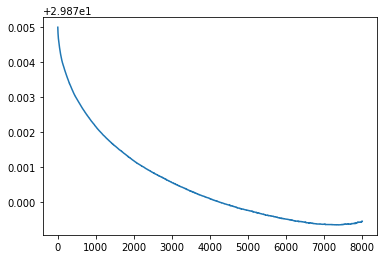

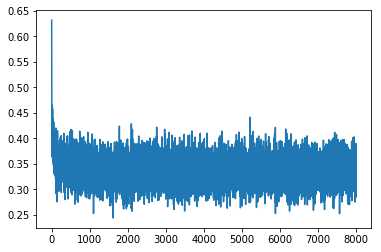

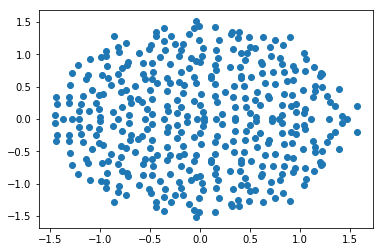

In [23]:
#plt.plot(len_h2h_grad)
#print(model.h2h.weight.detach().numpy().ravel()[np.where(model.h2h_mask.flatten())].std())
#print(g / np.sqrt(hidden_size * prob_conn))
plt.figure()
plt.plot(len_Wh2h)

plt.figure()
plt.plot(losses)

l,v = np.linalg.eig(model.h2h.weight.data)
plt.figure()
plt.scatter(np.real(l),np.imag(l))

0.249575

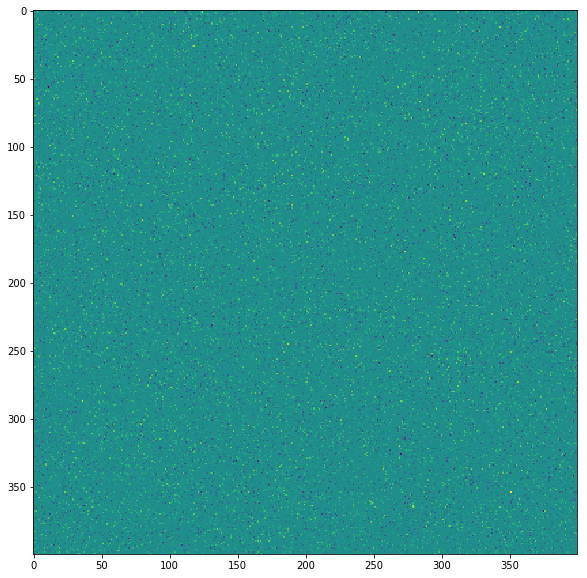

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(model.h2h.weight.detach().numpy(), interpolation='none', cmap='viridis')

(~np.isclose(h2h,0)).sum() / h2h.size
# np.savez('model_g1.5.npz',model.i2h.weight.detach().numpy(), model.h2h.weight.detach().numpy(), model.h2o.weight.detach().numpy())
#model.h2h.weight.detach().numpy().ravel()[np.where(~(model.h2h_mask != 0).flatten())].min()

In [ ]:
# ix = np.where(Wh2h[0])
# h2h_nz = Wh2h[:,ix[0],ix[1]]
#_ = plt.hist(np.diff(h2h_nz).sum(1))
# plt.figure(figsize=(10,10))
# plt.imshow(Wh2h[0], interpolation = 'none')

# Intrinsic dynamics -- Post-training

In [13]:
test_steps = 2500
test_batch_size = 8

with torch.no_grad():
    hidden = 2*torch.rand((test_batch_size, hidden_size))-1
    out, hid = model(torch.zeros(test_batch_size, test_steps, input_size), hidden)
    intrinsic_out = out.detach().numpy()
    intrinsic_hid = hid.detach().numpy()

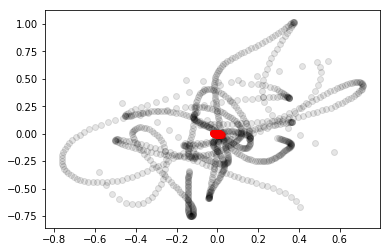

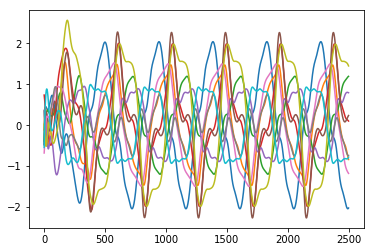

In [15]:
plt.figure()
plt.scatter(*intrinsic_out[:,:int(test_steps/20),:].T, color = 'k', alpha = 0.1)
plt.scatter(*intrinsic_out[:,-int(test_steps/20):,:].T, color = 'r', alpha = 0.1)

plt.figure()
i=np.random.randint(test_batch_size)
k=np.random.randint(0, hidden_size, 10)
_ = plt.plot(intrinsic_hid[i,:,k].T)

#     plt.xlim([-1,1])
#     plt.ylim([-1,1])
#plt.scatter(*targets[:,0,:].numpy().T, color='r')
# TODO?: convex hull of samples vs time, as a measure of convergence to single FP

# Stimulus-Evoked Dynamics


In [16]:
final_steps = 1000
test_batch_size = 8

with torch.no_grad():
    inputs, targets = get_batch(input_size, xmin, xmax, test_batch_size, n_steps, pulse_width)
    test_targ = targets[:,-1,:].numpy()
    hidden = 2*torch.rand((test_batch_size, hidden_size))-1
    out, hid = model(torch.cat((torch.zeros(test_batch_size, init_steps, input_size), 
                                inputs,
                                torch.zeros(test_batch_size, final_steps, input_size)),
                              dim=1),
                     hidden)
    test_out = out.detach().numpy()
    test_hid = hid.detach().numpy()

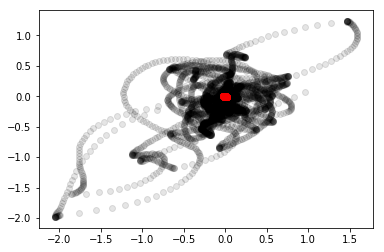

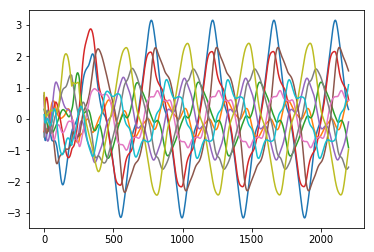

In [40]:
plt.figure()
plt.scatter(*test_out[:,:int(test_steps/5),:].T, color = 'k', alpha = 0.1)
plt.scatter(*test_out[:,-int(test_steps/5):,:].T, color = 'r', alpha = 0.1)

plt.figure()
i=np.random.randint(test_batch_size)
k=np.random.randint(0, hidden_size, 10)
_ = plt.plot(test_hid[i,:,k].T)

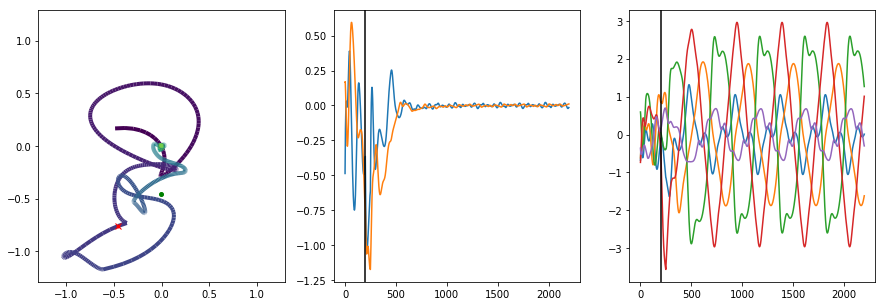

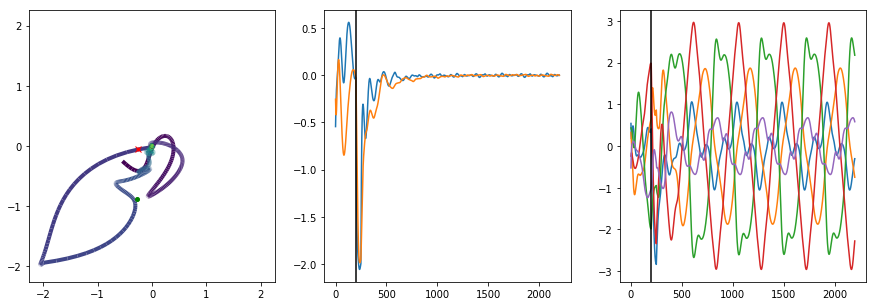

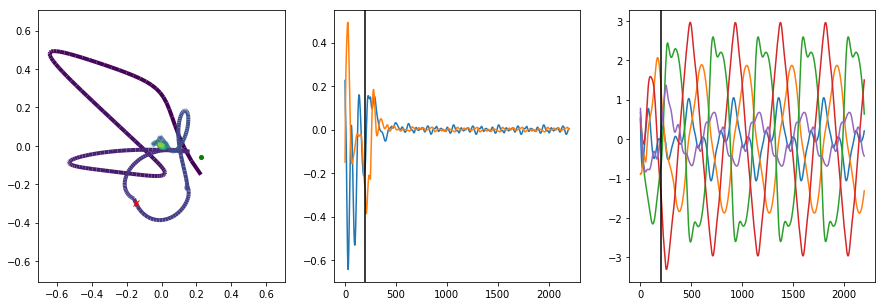

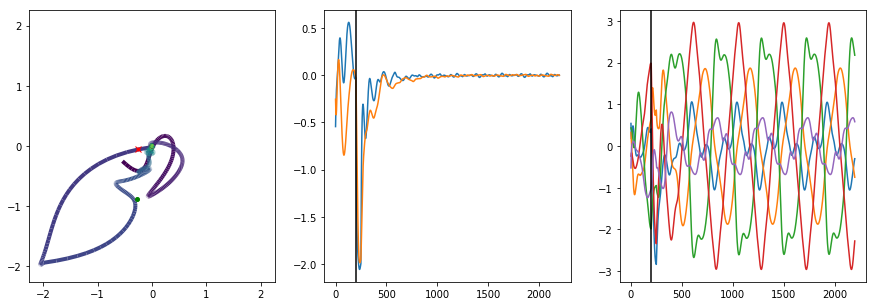

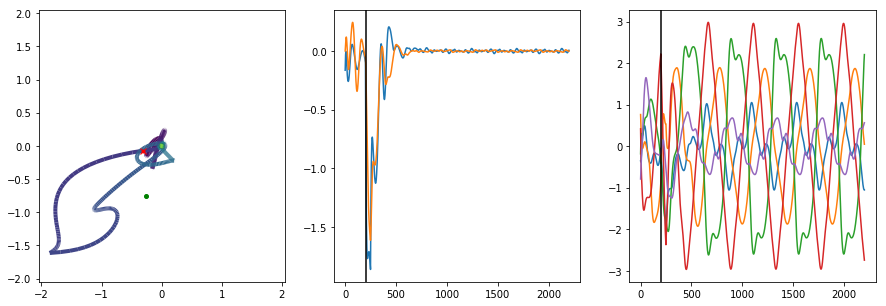

In [49]:
for i in np.random.randint(0,test_batch_size,5):
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    x,y = test_out[i,:500,:].T
    points = test_out[i].reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(0, init_steps + n_steps)
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(np.arange(init_steps + n_steps))
    lc.set_linewidth(4)
    line = ax[0].add_collection(lc)
    ax[0].plot(*test_out[i,init_steps].T, 'rx')
    ax[0].plot(*test_out[i,init_steps].T, 'r.')
    ax[0].plot(*test_targ[i].T, 'g.', markersize=8)
    pmax = 1.1*np.abs(points).max()
    ax[0].set_xlim(-pmax, pmax)
    ax[0].set_ylim(-pmax, pmax)
    ax[1].plot(test_out[i])
    ax[1].axvline(init_steps, color='k')
    ax[2].plot(test_hid[i,:,:5])
    ax[2].axvline(init_steps, color='k')
    

In [ ]:
hid_idx = np.random.randint(0,hidden_size,20)
fig, ax = plt.subplots(10,1,sharex=True, figsize=(5,10))
for axi, i in zip(ax.ravel(), hid_idx):
    axi.plot(test_hid[0,:,i].T)
#plt.figure()
#_ = plt.plot(test_hid[0,:,hid_idx].T)

In [ ]:
_ = plt.plot(test_hid[0,:,:10])

In [ ]:
cmats = []
# for i in range(n_test):
    for j in range(batch_size):
        cmats.append(np.corrcoef(test_hid[i,j].T))

#cmats = np.array(cmats).reshape(5,3)

In [ ]:
# fig, ax = plt.subplots(num_pats, num_test)
print(len(cmats))

for x in cmats[::batch_size]:
    plt.figure(figsize =(8,8))
    plt.imshow(x, interpolation = 'none')

In [ ]:
#i=0
# for j in np.random.randint(0,batch_size,10):
#     plt.figure()
#     for t in range(init_steps):
#         plt.scatter(*test_out[i,j,t,:].T, color='k', alpha=0.1+0.9*t/(init_steps+n_steps))
#     for t in range(init_steps,init_steps+100):
#         plt.scatter(*test_out[i,j,t,:].T, color='r', alpha=0.1+0.9*t/(init_steps+n_steps))
#     for t in range(init_steps+100,init_steps+n_steps):
#         plt.scatter(*test_out[i,j,t,:].T, color='b', alpha=0.1+0.9*t/(init_steps+n_steps))    
#     plt.scatter(*test_targ[i,j,:].T, color = 'g')
#     plt.gca().set_aspect('equal')
#     #plt.xlim([-2,2])
#     #plt.ylim([-2,2])

# for t in range():
#     plt.scatter(*test_out[0,0,t,:].T, color='r', alpha=0.1+0.9*t/200.)

#plt.scatter(*test_out[i,:,-int(test_steps/4):,:].T)
#plt.scatter(torch.cat((torch.zeros(batch_size, init_steps, input_size), inputs), dim=1)[:,100,:]

In [ ]:
# plt.figure()
# #for j in range(n_test):
# #     plt.plot(test_out[j,i,:100,0],
# #             test_out[j,i,:100,1])
# #     plt.plot(test_out[j,i,-100:,0],
# #             test_out[j,i,-100:,1])
#     #plt.scatter(*test_out[j,i,:int(test_steps/2),:].T)
#     #plt.scatter(*test_out[j,i,int(test_steps/2):,:].T)
#     plt.scatter(*test_out[j,i,:100,:].T)
# #    plt.xlim([-1,1])
# #    plt.ylim([-1,1])

# #plt.scatter(*targets[:,0,:].numpy().T, facecolor='r', edgecolor='k')
# # plt.scatter(*targets[:,0,:].numpy().T.mean(1), color='b')

In [ ]:
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

In [ ]:
from scipy import sparse
def testdummy(ni,nh,no,pc):
    #i2h = np.random.randn(ni,nh)
    #print(i2h.shape)
    #h2h = (1.5 / (np.sqrt(pc*nh))) * np.random.randn(nh,nh)
    mask = np.random.uniform(size=(nh,nh)) < pc
    mask *= ~np.eye(mask.shape[0]).astype(np.bool)
    row, col = np.where(mask)
    values = (1.5 / (np.sqrt(pc*nh))) * np.random.randn(len(row))
    h2h = sparse.csr_matrix((values, (row,col)), shape=mask.shape) #.todense()
    #h2h[np.where(~mask)[0],:][:,np.where(~mask)[1]] = 0.
    h2o = (1./np.sqrt(nh))*np.random.randn(no, nh)
    hidden = 2*np.random.uniform(size=(nh,1)) - 1
    dt = 0.1
    tau = 1
    hiddens = []
    outputs = []
    for i in range(1000):
        recur = h2h.dot(np.tanh(hidden))
        hidden = (1-dt)*hidden + dt*recur
        output = h2o.dot(hidden)
        hiddens.append(hidden)
        outputs.append(output)

    return np.squeeze(np.array(hiddens)), np.squeeze(np.array(outputs))

h,o = testdummy(input_size, hidden_size, input_size, 0.25)

# # plt.plot()
k=np.random.randint(0, hidden_size, 10)
plt.plot(h[:,k])
plt.figure()
plt.scatter(*o.T)

In [ ]:
# idx = np.random.choice()
def testdummy2(i2h,h2h,h2o,hidden=None):
    dt = 0.1
    tau = 1
    hiddens = []
    outputs = []
    if hidden is None:
        hidden = 2*np.random.uniform(size=(h2h.shape[0],1)) - 1

    for i in range(1000):
        recur = h2h.dot(np.tanh(hidden))
        hidden = (1-dt)*hidden + dt*recur
        output = h2o.dot(hidden)
        hiddens.append(hidden)
        outputs.append(output)

    return np.squeeze(np.array(hiddens)), np.squeeze(np.array(outputs))


test_hidden = 2*torch.rand((1, hidden_size))-1
h,o  = testdummy2(i2h, h2h, h2o, hidden=test_hidden.detach().numpy().T)
k=np.random.randint(0, hidden_size, 10)
plt.plot(h[:,k])
plt.figure()
plt.scatter(*o.T)